In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
plt.rcParams["figure.facecolor"] = "w"
sns.set(style="darkgrid")

In [72]:
df1 = pd.read_csv('brick.csv')
df1['Date'] = pd.to_datetime(df1['Date'], format="%d/%m/%Y")
df1 = df1.set_index('Date')

In [73]:
df2 = pd.read_csv('plastic.csv')
df2['Date'] = pd.to_datetime(df2['Date'], format="%d/%m/%Y")
df2 = df2.set_index('Date')

In [82]:
df = pd.read_csv('brick.csv')
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")
df = df.set_index('Date')

In [75]:
df2

,Value
Date,
2022-01-01,113.3
2022-02-01,113.8
2022-03-01,115.0
2022-04-01,115.8
2022-05-01,116.4
...,...
2012-08-01,103.0
2012-09-01,103.1
2012-10-01,104.0


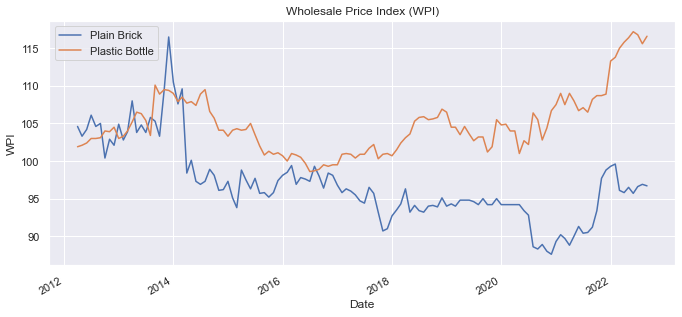

In [107]:
fig, ax = plt.subplots(figsize=(10, 5))

df1.plot(ax=ax, label='Plain Brick', title='Wholesale Price Index (WPI)')
df2.plot(ax=ax, label='Plastic Bottle')
ax.legend(['Plain Brick', 'Plastic Bottle'])
plt.xlabel('Date')
plt.ylabel('WPI')

plt.show()

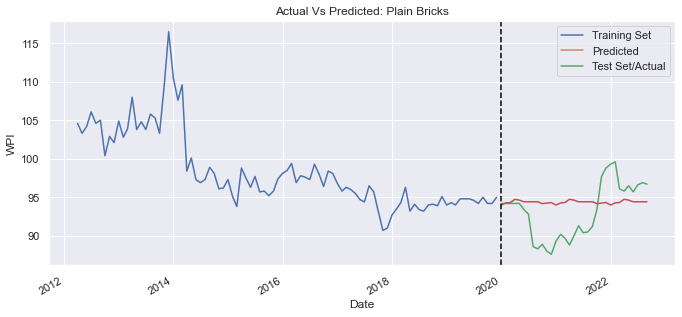

In [111]:
train = df.loc[df.index < '01-01-2020']
test = df.loc[df.index >= '01-01-2020']

fig, ax = plt.subplots(figsize=(10, 5))
train.plot(ax=ax, label='Training Set', title='Actual Vs Predicted: Plain Bricks')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2020', color='black', ls='--')
ax.legend(['Training Set', 'Predicted','Test Set/Actual'])
plt.xlabel('Date')
plt.ylabel('WPI')
plt.show()

In [112]:
def create_features(df):
    
    df = df.copy()
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    return df

df = create_features(df)

In [67]:
train = create_features(train)
test = create_features(test)

FEATURES = ['quarter', 'month', 'year']
TARGET = 'Value'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [68]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[12:11:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[12:11:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stopping_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:96.96890	validation_1-rmse:91.72518
[100]	validation_0-rmse:36.16451	validation_1-rmse:30.84753
[200]	validation_0-rmse:13.82130	validation_1-rmse:10.64834
[300]	validation_0-rmse:5.72882	validation_1-rmse:4.47890
[400]	validation_0-rmse:2.86439	validation_1-rmse:3.56285
[500]	validation_0-rmse:1.88619	validation_1-rmse:3.59739
[600]	validation_0-rmse:1.44170	validation_1-rmse:3.67794
[700]	valida

C:\Users\tozhy\AppData\Roaming\Python\Python39\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[999]	validation_0-rmse:0.99917	validation_1-rmse:3.77463


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=50,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=16,
             num_parallel_tree=1, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [70]:
from sklearn.metrics import r2_score

r2_score(test['prediction'].values, y_test.values)

-385.0951112771077

C:\Users\tozhy\AppData\Local\Temp\ipykernel_10308\314331645.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


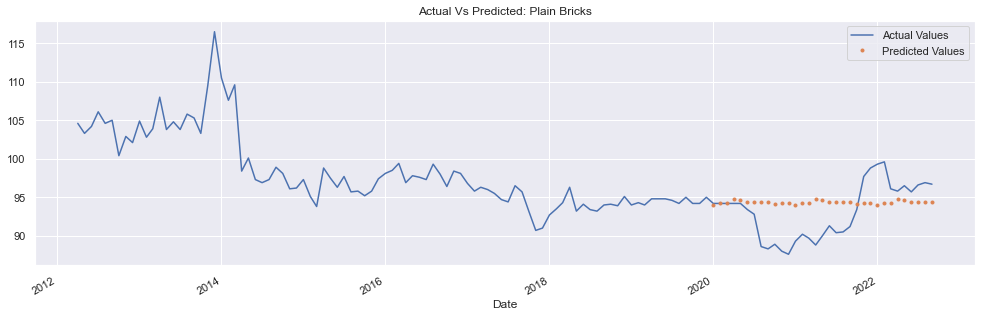

In [104]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['Value']].plot(figsize=(15, 5))
test['prediction'].plot(ax=ax, style='.')
plt.legend(['Actual Values', 'Predicted Values'])
ax.set_title('Actual Vs Predicted: Plain Bricks')
plt.show()